# Enriching a Synthetic Population with Propensity Score Matching using EPC and SPENSER for Haringey LAD

In this notebook we present the steps made to "merge" the EPC data and the SPENSER population for one local authority district.

- The code here follows the instructions presented [here](https://github.com/anetobradley/energy_flex/blob/main/01-ActivityModel/step2/README.md).
- The enriched population produced here, can be found [here](https://github.com/anetobradley/energy_flex/blob/main/01-ActivityModel/output/msm_england_epc.zip), and the variables description for this population can be found [here](https://github.com/anetobradley/energy_flex/blob/main/01-ActivityModel/output/msm_england_epc_metadata.md).

## Initialisation

### Import necessary modules

In [1]:
import pandas as pd
import zipfile
import os
from causalinference import CausalModel
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
from random import choices
%matplotlib inline

### Import data

#### Import Energy Performance Certificate (EPC) data

In [2]:
ladcd = 'E09000014' # local authority for testing: Haringey

epc_zip_file = zipfile.ZipFile(os.path.join('../inputs/data', 'epc_england.zip'))
epc_file = ".".join([ladcd, 'csv'])
epc_df = pd.read_csv(epc_zip_file.open(epc_file))
epc_df.rename({"LC4402_C_TENHUK11": "tenure"}, axis=1, inplace=True)
epc_df.head()

,Area,FLOOR_AREA,LC4404_C_ROOMS,MAINHEAT_DESCRIPTION,ACCOM_AGE,tenure,LC4402_C_TYPACCOM
0,E00010316,1,3,"Boiler and radiators, mains gas",4,5,5
1,E00010336,3,2,"Boiler and radiators, mains gas",1,5,5
2,E00010168,1,1,"Room heaters, electric",1,6,5
3,E00009985,2,4,"Boiler and radiators, mains gas",1,6,5
4,E00010505,3,4,Portable electric heaters assumed for most rooms,1,1,4


#### Import Synthetic Population (SPENSER) data

In [3]:
spenser_zip_file = zipfile.ZipFile(os.path.join('../inputs/data', 'msm_england.zip'))
spenser_file = "_".join(['msm_england/ass_hh', ladcd, 'OA11_2020.csv'])
spenser_df = pd.read_csv(spenser_zip_file.open(spenser_file))
spenser_df.head()

,HID,Area,LC4402_C_TYPACCOM,QS420_CELL,LC4402_C_TENHUK11,LC4408_C_AHTHUK11,CommunalSize,LC4404_C_SIZHUK11,LC4404_C_ROOMS,LC4405EW_C_BEDROOMS,LC4408EW_C_PPBROOMHEW11,LC4402_C_CENHEATHUK11,LC4605_C_NSSEC,LC4202_C_ETHHUK11,LC4202_C_CARSNO,HRPID,FILLED
0,0.0,E00010088,3.0,-2.0,3.0,3.0,-2.0,2.0,4.0,2.0,-1.0,2.0,2.0,2.0,2.0,254841.0,True
1,1.0,E00010222,2.0,-2.0,5.0,1.0,-2.0,1.0,3.0,1.0,-1.0,2.0,9.0,7.0,1.0,269214.0,True
2,2.0,E00010300,5.0,-2.0,6.0,2.0,-2.0,4.0,6.0,4.0,-1.0,2.0,4.0,4.0,1.0,206340.0,False
3,3.0,E00010394,-2.0,-2.0,-1.0,-1.0,-2.0,0.0,1.0,1.0,-1.0,2.0,-1.0,-1.0,1.0,-1.0,False
4,4.0,E00010345,5.0,-2.0,6.0,3.0,-2.0,2.0,4.0,1.0,-1.0,2.0,5.0,4.0,1.0,258891.0,True


## Data Preparation

### SPENSER data: transform tenure values 2 and 3 to 1

In the EPC data the tenure values 2 (`Owned outright`) and 3 (`Owned with a mortgage or loan or shared ownership`) are aggregated in the value 1 (`Owned: Total`).

In [4]:
df_col = 'tenure'
spenser_df[df_col] = spenser_df.LC4402_C_TENHUK11.copy()
spenser_df.loc[(spenser_df[df_col] == 2), df_col] = 1 # 2 = Owned outright
spenser_df.loc[(spenser_df[df_col] == 3), df_col] = 1 # 3 = Owned with a mortgage or loan or shared ownership

### Assign a treatment values

* EPC: `Treatment` = 1
* SPENSER: `Treatment` = 0

In [5]:
epc_df['Treatment'] = 1
spenser_df['Treatment'] = 0

### Concatenate EPC and SPENSER datasets 

In [6]:
dataset = pd.concat([spenser_df, epc_df], ignore_index=True, sort=False)

### Factorizing the Area

Arbitrarily encode the object as an enumerated type.

> No assumptions are made regarding distance between different areas.

In [7]:
Area_factor = dataset.Area.factorize()
dataset['Area_factor'] = Area_factor[0]

### Isolate the Y, X and the covariates

In [8]:
Y = dataset.Treatment.copy()  # arbitrary outcome
X = dataset.Treatment.copy()  # treatment

overlap_columns = ['LC4402_C_TYPACCOM', 'tenure', 'Area_factor'] 
covariates = dataset[overlap_columns]

### Transform categorical into dummy variables

To use `CausalModel`, data must be numerical (integer or real). If any variable is categorical, you can use the command below to transform it into dummy values:

```python
Y = pd.get_dummies(data=Y, drop_first=True)
X = pd.get_dummies(data=X, drop_first=True)
covariates = pd.get_dummies(data=covariates, drop_first=True)
```

> In this work, the data went through a previous process where the variables were coded.

### Transform pandas dataframe into numpy.ndarray

In [9]:
Y = Y.values
X = X.values
covariates = covariates.values

## Propensity score

In [10]:
# Create the Causal Model
model = CausalModel(Y, X, covariates)

# Calculate the propensity score
model.est_propensity_s()

# Store the propensity score
dataset['PropensityScore'] = model.propensity['fitted']

### Propensity score comparison

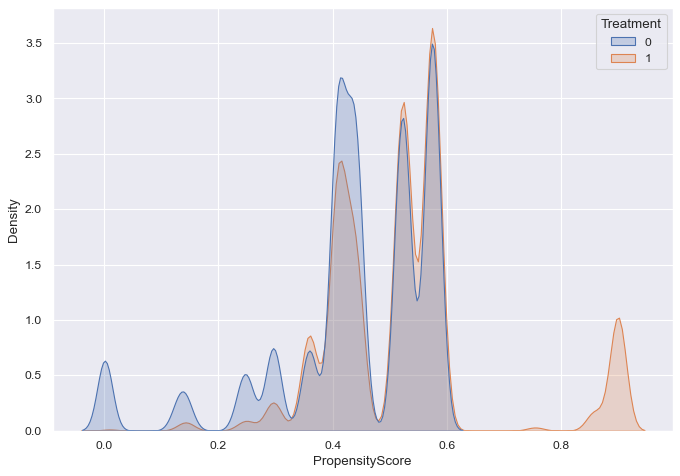

In [11]:
plt.figure(figsize=(10,7), dpi= 80)
sns.kdeplot(dataset['PropensityScore'], hue=dataset['Treatment'], shade=True)

# * SPENSER: `Treatment` = 0
# * EPC: `Treatment` = 1


## Match Process

### Separating EPC data from SPENSER data

In [12]:
epc_df = dataset.loc[dataset.Treatment==1].reset_index(drop=True)
spenser_df = dataset.loc[dataset.Treatment==0].reset_index(drop=True)

### Closest neighbors

#### Defining the number of neighbors

In [13]:
n_neighbors = 200  # number of neighbors to be stored for each hid in SPENSER data

#### Creating a list of closest neighbors (index and distance)

In [14]:
# create the neighbors object (p=2 means Euclidean distance)
knn = NearestNeighbors(n_neighbors=n_neighbors, p=2).fit(epc_df[['PropensityScore']])

# for each household in SPENSER dataframe, find the nearest EPC neighbors
distances, indices = knn.kneighbors(spenser_df[['PropensityScore']])

#### Weight function example - SPENSER household id=4

Text(0, 0.5, 'Wheight')

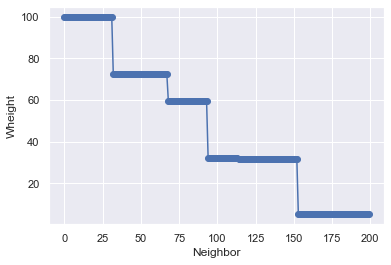

In [15]:
import numpy as np

i = 4  # SPENSER household id
N = 100  # max weight value
M = 5  # min weight values

delta_Pij = distances[i]
delta_Pin = distances[i][-1]

weight = N-((delta_Pij/delta_Pin)*(N-M))


x = np.arange(0, n_neighbors)
plt.plot(x,weight, 'o-')
plt.xlabel('Neighbor')
plt.ylabel('Wheight')

### Defining Matching Function

In [16]:
def get_matches(distances, indices):
    pairs = []
    for indexSPENSER, candidatesEPC in  enumerate(indices):
        is_zero = np.flatnonzero(distances[indexSPENSER]==0)
        if is_zero.size < n_neighbors:
            weight = (100-(distances[indexSPENSER]/distances[indexSPENSER][-1]*95))
            indexEPC = choices(candidatesEPC, weights=weight)[0] # random.choices not supported by numba
        else:
            indexEPC = choices(candidatesEPC)[0]
        
        
        pairs.append([indexSPENSER, indexEPC])
    return(pairs)

### Get matched pairs

In [17]:
pairs = get_matches(distances, indices)

#### Add matched EPC id in SPENSER dataframe

In [18]:
matches = pd.DataFrame(pairs)
spenser_df["EPCid"] = matches[1]
del matches, pairs

### Get EPC information

In [19]:
spenser_df.drop(["tenure", 
             "Treatment", 
             "FLOOR_AREA", 
             "MAINHEAT_DESCRIPTION",
             "ACCOM_AGE",
             "Area_factor",
             "PropensityScore",], axis=1, inplace=True)
spenser_df.head()

,HID,Area,LC4402_C_TYPACCOM,QS420_CELL,LC4402_C_TENHUK11,LC4408_C_AHTHUK11,CommunalSize,LC4404_C_SIZHUK11,LC4404_C_ROOMS,LC4405EW_C_BEDROOMS,LC4408EW_C_PPBROOMHEW11,LC4402_C_CENHEATHUK11,LC4605_C_NSSEC,LC4202_C_ETHHUK11,LC4202_C_CARSNO,HRPID,FILLED,EPCid
0,0.0,E00010088,3.0,-2.0,3.0,3.0,-2.0,2.0,4.0,2.0,-1.0,2.0,2.0,2.0,2.0,254841.0,True,1664
1,1.0,E00010222,2.0,-2.0,5.0,1.0,-2.0,1.0,3.0,1.0,-1.0,2.0,9.0,7.0,1.0,269214.0,True,106334
2,2.0,E00010300,5.0,-2.0,6.0,2.0,-2.0,4.0,6.0,4.0,-1.0,2.0,4.0,4.0,1.0,206340.0,False,74926
3,3.0,E00010394,-2.0,-2.0,-1.0,-1.0,-2.0,0.0,1.0,1.0,-1.0,2.0,-1.0,-1.0,1.0,-1.0,False,48772
4,4.0,E00010345,5.0,-2.0,6.0,3.0,-2.0,2.0,4.0,1.0,-1.0,2.0,5.0,4.0,1.0,258891.0,True,76262


In [20]:
columns = ['FLOOR_AREA', 'MAINHEAT_DESCRIPTION', 'ACCOM_AGE']
epc_df = epc_df[columns].copy()
epc_df['EPCid'] = epc_df.index

In [21]:
spenser_df = pd.merge(spenser_df, epc_df, on='EPCid',how='left')
spenser_df.head()

,HID,Area,LC4402_C_TYPACCOM,QS420_CELL,LC4402_C_TENHUK11,LC4408_C_AHTHUK11,CommunalSize,LC4404_C_SIZHUK11,LC4404_C_ROOMS,LC4405EW_C_BEDROOMS,...,LC4402_C_CENHEATHUK11,LC4605_C_NSSEC,LC4202_C_ETHHUK11,LC4202_C_CARSNO,HRPID,FILLED,EPCid,FLOOR_AREA,MAINHEAT_DESCRIPTION,ACCOM_AGE
0,0.0,E00010088,3.0,-2.0,3.0,3.0,-2.0,2.0,4.0,2.0,...,2.0,2.0,2.0,2.0,254841.0,True,1664,13.0,"Boiler and radiators, mains gas",2.0
1,1.0,E00010222,2.0,-2.0,5.0,1.0,-2.0,1.0,3.0,1.0,...,2.0,9.0,7.0,1.0,269214.0,True,106334,14.0,"Boiler and radiators, mains gas",3.0
2,2.0,E00010300,5.0,-2.0,6.0,2.0,-2.0,4.0,6.0,4.0,...,2.0,4.0,4.0,1.0,206340.0,False,74926,1.0,"Room heaters, electric",1.0
3,3.0,E00010394,-2.0,-2.0,-1.0,-1.0,-2.0,0.0,1.0,1.0,...,2.0,-1.0,-1.0,1.0,-1.0,False,48772,11.0,Community scheme,-1.0
4,4.0,E00010345,5.0,-2.0,6.0,3.0,-2.0,2.0,4.0,1.0,...,2.0,5.0,4.0,1.0,258891.0,True,76262,2.0,"Boiler and radiators, mains gas",1.0


## Internal validation

### Floor area distribution

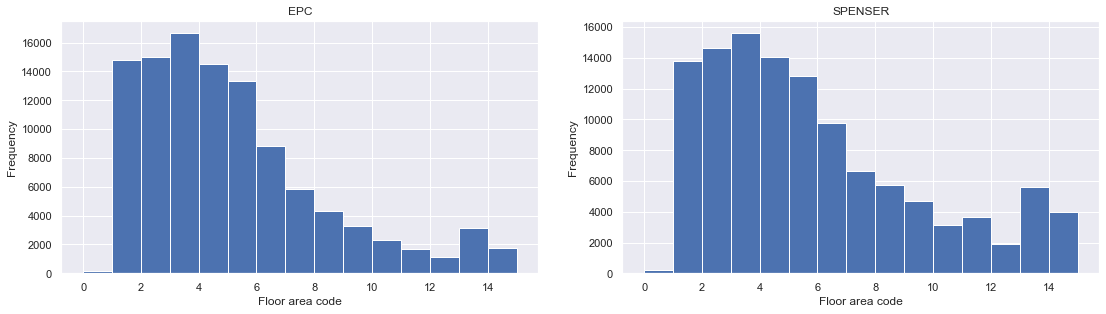

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

spenser_df.FLOOR_AREA.plot(kind='hist', ax=ax[1], title="SPENSER", bins=15)
epc_df.FLOOR_AREA.plot(kind='hist', ax=ax[0], title="EPC", bins=15)

ax[0].set_xlabel('Floor area code')
ax[1].set_xlabel('Floor area code')

fig.tight_layout(pad=3.0)


### Accommodation age distribution

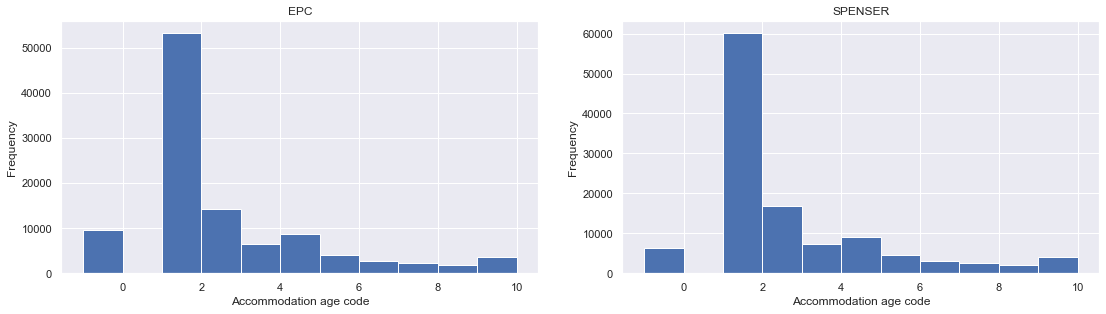

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

spenser_df.ACCOM_AGE.plot(kind='hist', ax=ax[1], title="SPENSER", bins=11)
epc_df.ACCOM_AGE.plot(kind='hist', ax=ax[0], title="EPC", bins=11)

ax[0].set_xlabel('Accommodation age code')
ax[1].set_xlabel('Accommodation age code')

fig.tight_layout(pad=3.0)


## Saving Enriched Population

In [24]:
list_df_names = ['msm_E09000014_epc.csv']
list_df = [spenser_df]
csv_name = '../output/msm_england_epc.zip'
with zipfile.ZipFile(csv_name, 'w') as csv_zip:
    for i in range(len(list_df_names)):
        csv_zip.writestr(list_df_names[i], list_df[i].to_csv(index = False, header=True))

## Final comments

* The `MAINHEAT_DESCRIPTION` column has different values just for `Haringey`. 
    * If we consider all Local Authorities this number exceeds 700 values, making it difficult to code. 
    * So far they are being passed literally.
    * The ideal is to create different categories and organize the data according to them.
    * Without the proper organization, it is impossible to carry out any kind of validation.